In [20]:
!pip install pyspark

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("MovieRecommendation").getOrCreate()


In [22]:
# Read in data
ratings = spark.read.csv('/content/sample_data/ml-latest-small/ratings.csv', header=True, inferSchema=True)

# Take a look at the data
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [23]:
# Get the dataset information
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [24]:
# Number of users
print('The ratings dataset has', ratings.select("userId").distinct().count(), 'unique users')

# Number of movies
print('The ratings dataset has', ratings.select("movieId").distinct().count(), 'unique movies')

# Number of ratings
print('The ratings dataset has', ratings.select("rating").distinct().count(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(ratings.select("rating").distinct().rdd.flatMap(lambda x: x).collect()))

The ratings dataset has 610 unique users
The ratings dataset has 9724 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [25]:
# Read in data
movies = spark.read.csv('/content/sample_data/ml-latest-small/movies.csv', header=True, inferSchema=True)

# Take a look at the data
movies.show()


+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [26]:
# Merge ratings and movies datasets
df = ratings.join(movies, on='movieId', how='inner')

# Take a look at the data
df.show()


+-------+------+------+---------+--------------------+--------------------+
|movieId|userId|rating|timestamp|               title|              genres|
+-------+------+------+---------+--------------------+--------------------+
|      1|     1|   4.0|964982703|    Toy Story (1995)|Adventure|Animati...|
|      3|     1|   4.0|964981247|Grumpier Old Men ...|      Comedy|Romance|
|      6|     1|   4.0|964982224|         Heat (1995)|Action|Crime|Thri...|
|     47|     1|   5.0|964983815|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|     1|   5.0|964982931|Usual Suspects, T...|Crime|Mystery|Thr...|
|     70|     1|   3.0|964982400|From Dusk Till Da...|Action|Comedy|Hor...|
|    101|     1|   5.0|964980868|Bottle Rocket (1996)|Adventure|Comedy|...|
|    110|     1|   4.0|964982176|   Braveheart (1995)|    Action|Drama|War|
|    151|     1|   5.0|964984041|      Rob Roy (1995)|Action|Drama|Roma...|
|    157|     1|   5.0|964984100|Canadian Bacon (1...|          Comedy|War|
|    163|   

In [27]:
from pyspark.sql.functions import mean, count
agg_ratings = df.groupBy('title').agg(
    mean('rating').alias('mean_rating'),
    count('rating').alias('number_of_ratings')
)

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings.filter(col('number_of_ratings') > 100)

# Show information about the resulting DataFrame
agg_ratings_GT100.printSchema()
agg_ratings_GT100.show()

root
 |-- title: string (nullable = true)
 |-- mean_rating: double (nullable = true)
 |-- number_of_ratings: long (nullable = false)

+--------------------+------------------+-----------------+
|               title|       mean_rating|number_of_ratings|
+--------------------+------------------+-----------------+
|Men in Black (a.k...| 3.487878787878788|              165|
|Kill Bill: Vol. 2...| 3.868181818181818|              110|
|Eternal Sunshine ...|4.1603053435114505|              131|
|Dumb & Dumber (Du...|3.0601503759398496|              133|
|Indiana Jones and...| 3.638888888888889|              108|
|      Jumanji (1995)|3.4318181818181817|              110|
|        Ghost (1990)|3.4347826086956523|              115|
|Raiders of the Lo...|            4.2075|              200|
|     Outbreak (1995)|3.4257425742574257|              101|
|    Rock, The (1996)|3.6404958677685952|              121|
|2001: A Space Ody...|3.8944954128440368|              109|
|        Speed (1994)|3.52

In [28]:
popular_movies = agg_ratings_GT100.orderBy('number_of_ratings', ascending=False).limit(5).toPandas()
print(popular_movies)

                              title  mean_rating  number_of_ratings
0               Forrest Gump (1994)     4.164134                329
1  Shawshank Redemption, The (1994)     4.429022                317
2               Pulp Fiction (1994)     4.197068                307
3  Silence of the Lambs, The (1991)     4.161290                279
4                Matrix, The (1999)     4.192446                278


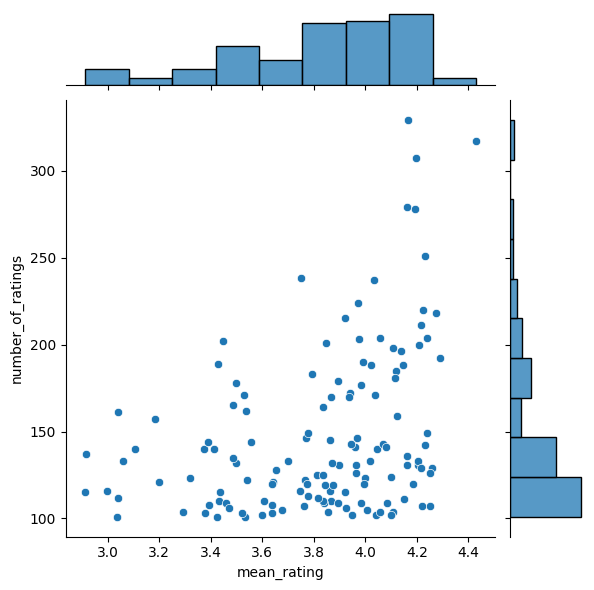

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


# Convert PySpark DataFrame to Pandas DataFrame
agg_ratings_GT100_pd = agg_ratings_GT100.toPandas()
# Visualization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100_pd)
plt.show()

In [30]:
df_GT100 = df.join(agg_ratings_GT100.select('title'), on='title', how='inner')
df_GT100.printSchema()

root
 |-- title: string (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- genres: string (nullable = true)



In [31]:
# Number of users
num_users = df_GT100.select('userId').distinct().count()
print(f'The ratings dataset has {num_users} unique users')

# Number of movies
num_movies = df_GT100.select('movieId').distinct().count()
print(f'The ratings dataset has {num_movies} unique movies')

# Number of ratings
num_ratings = df_GT100.select('rating').distinct().count()
print(f'The ratings dataset has {num_ratings} unique ratings')

# List of unique ratings
unique_ratings = sorted(df_GT100.select('rating').distinct().rdd.flatMap(lambda x: x).collect())
print(f'The unique ratings are {unique_ratings}')

The ratings dataset has 597 unique users
The ratings dataset has 134 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [32]:
from pyspark.sql.functions import col

# Assuming `df_GT100` is the PySpark DataFrame from the previous code

# Create user-item matrix
matrix = df_GT100.groupBy('userId', 'title').pivot('title').agg({"rating": "first"})

# Fill missing values with 0 (assuming missing values mean no rating)
matrix = matrix.fillna(0)

# Show the resulting matrix
matrix.show()

+------+--------------------+----------------------------+---------------------------------+--------------+------------+-------------+----------------------------------------------------+----------------------+-------------------------+-------------------+---------------------+----------------+--------------------------------------------+-----------+-------------------------+-------------+--------------------+---------------------+------------------------+---------------------------+------------------------+-------------------+---------------------------+-----------------+--------------------------+--------------------------+-------------------------------+-------------+------------------+--------------------------+---------------+-------------------+-------------------------------------------------------+-------------------------+-----------------------+--------------------+---------------+---------------------------------+-------------------+--------------------------------------+---

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
# Create user-item matrix
matrix = df_GT100.groupBy('userId', 'title').agg(F.mean('rating').alias('rating'))
user_item_matrix = matrix.groupBy('userId').pivot('title').agg(F.first('rating'))

# Show the user-item matrix
user_item_matrix.show()



In [35]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming `matrix` is the PySpark DataFrame from the previous code

# Extract the average rating for each user
user_avg_ratings = matrix.select(
    'userId',
    *(F.mean(F.col(col)).over(Window.partitionBy('userId')).alias(f'{col}_avg') for col in matrix.columns[2:])
)

# Join the average ratings back to the user-item matrix
matrix_normalized = matrix.join(
    user_avg_ratings, on='userId', how='inner'
)

# Normalize the user-item matrix
normalized_cols = [
    ((F.col(col) - F.col(f'{col}_avg')).alias(col))
    for col in matrix.columns[2:]
]

matrix_normalized = matrix_normalized.select('userId', 'title', *normalized_cols)

# Show the normalized user-item matrix
matrix_normalized.show()


+------+--------------------+--------------------+
|userId|               title|              rating|
+------+--------------------+--------------------+
|     1| Pulp Fiction (1994)| -1.3928571428571432|
|     1|Star Wars: Episod...|  0.6071428571428568|
|     1|American History ...|  0.6071428571428568|
|     1|Dances with Wolve...|-0.39285714285714324|
|     1|Monty Python and ...|  0.6071428571428568|
|     1|      Twister (1996)| -1.3928571428571432|
|     1|Jurassic Park (1993)|-0.39285714285714324|
|     1|Clear and Present...|-0.39285714285714324|
|     1|   Braveheart (1995)|-0.39285714285714324|
|     1|Fugitive, The (1993)|  0.6071428571428568|
|     1|  Matrix, The (1999)|  0.6071428571428568|
|     1|Full Metal Jacket...|  0.6071428571428568|
|     1|    Toy Story (1995)|-0.39285714285714324|
|     1|Willy Wonka & the...|  0.6071428571428568|
|     1|         Heat (1995)|-0.39285714285714324|
|     1|Ghostbusters (a.k...|  0.6071428571428568|
|     1|        X-Men (2000)|  